<a href="https://colab.research.google.com/github/RaiShra1/Computer-Vision-and-Image-Processing/blob/main/Objectron_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Thu Mar 18 19:03:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [9]:
!git clone https://github.com/google-research-datasets/Objectron/

Cloning into 'Objectron'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (137/137), done.
remote: Total 187 (delta 85), reused 134 (delta 45), pack-reused 0
Receiving objects: 100% (187/187), 39.44 MiB | 17.58 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [12]:
cd Objectron/

/content/drive/My Drive/Objectron


In [13]:
objectron_buckett = 'gs://objectron/v1/records_shuffled'
NUM_PARALLEL_CALLS = 4
WIDTH = 480
HEIGHT = 640
NUM_CHANNELS = 3
# The 3D bounding box has 9 vertices, 0: is the center, and the 8 vertices of the 3D box.
NUM_KEYPOINTS = 9
BATCH_SIZE = 4

In [21]:
!pip install frozendict

  Created wheel for frozendict: filename=frozendict-1.2-cp37-none-any.whl size=3150 sha256=095d82a82be66651f390a06f1fc6fa747cfebe37561bb1677519f9e13658a05a
  Stored in directory: /root/.cache/pip/wheels/6c/6c/e9/534386165bd12cf1885582c75eb6d0ffcb321b65c23fe0f834
Successfully built frozendict


In [22]:
import glob
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from objectron.schema import features
from objectron.dataset import box
from objectron.dataset import graphics

In [30]:
def parse(example):
  """Parses a single tf.Example and decode the `png` string to an array."""
  data = tf.io.parse_single_example(example, features = features.FEATURE_MAP)
  data['image'] = tf.image.decode_png(data[features.FEATURE_NAMES['IMAGE_ENCODED']], channels=NUM_CHANNELS)
  data['image'].set_shape([HEIGHT, WIDTH, NUM_CHANNELS])
  return data 

def augment(data):
  return data

def normalize(data):
  """Convert `image` from [0, 255] -> [-1., 1.] floats."""
  data['image'] = tf.cast(data['image'], tf.float32) * (2. / 255.) - 1.0  
  return data

def load_tf_record(input_record):
  dataset = tf.data.TFRecordDataset(input_record)

  dataset = dataset.map(parse, num_parallel_calls = NUM_PARALLEL_CALLS)\
                   .map(augment, num_parallel_calls = NUM_PARALLEL_CALLS)\
                   .map(normalize, num_parallel_calls = NUM_PARALLEL_CALLS)
  # Our TF.records are shuffled in advance. If you re-generate the dataset from the video files, you'll need to
  # shuffle your examples. Keep in mind that you cannot shuffle the entire datasets using dataset.shuffle, since 
  # it will be very slow.
  dataset = dataset.shuffle(100)\
                   .repeat()\
                   .batch(BATCH_SIZE)\
                   .prefetch(buffer_size=10)
  return dataset


In [40]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/cup/cup_train*')
dataset = load_tf_record(training_shards)

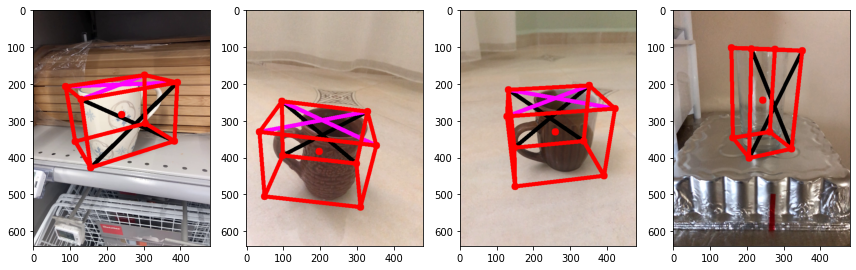

In [41]:
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

In [42]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/bike/bike_train*')
dataset = load_tf_record(training_shards)

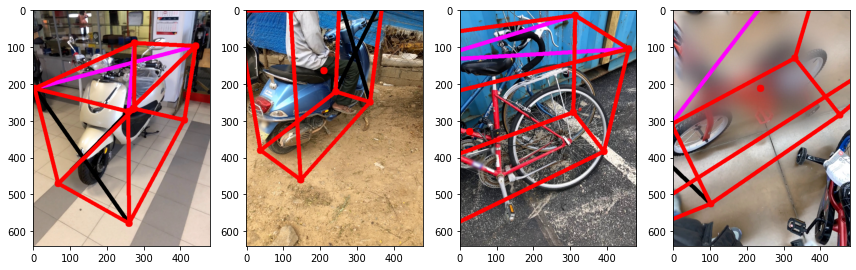

In [43]:
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

In [44]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/book/book_train*')
dataset = load_tf_record(training_shards)

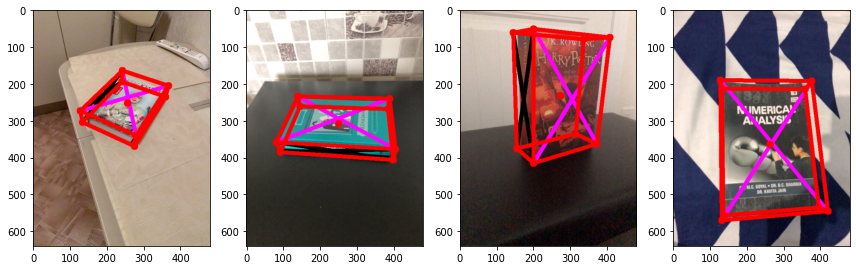

In [45]:
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

In [46]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/shoe/shoe_train*')
dataset = load_tf_record(training_shards)

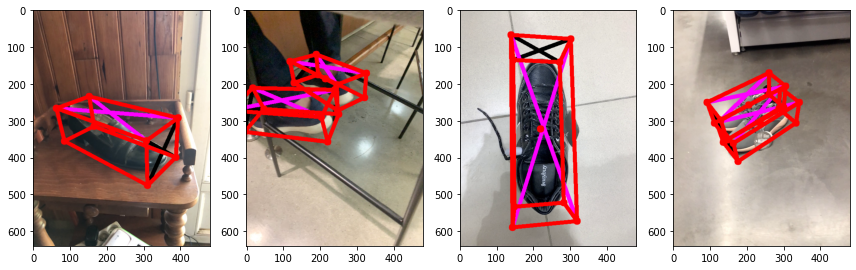

In [47]:
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

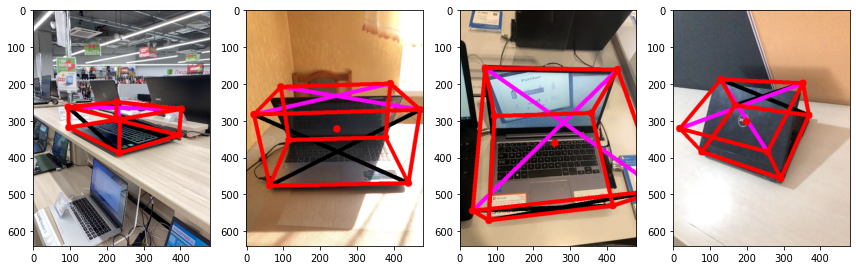

In [38]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/laptop/laptop_train*')
dataset = load_tf_record(training_shards)
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

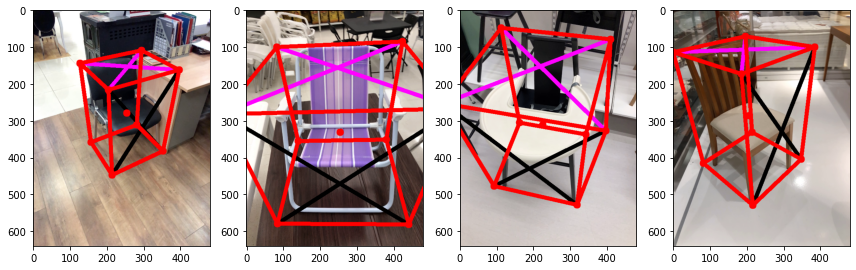

In [39]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/chair/chair_train*')
dataset = load_tf_record(training_shards)
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

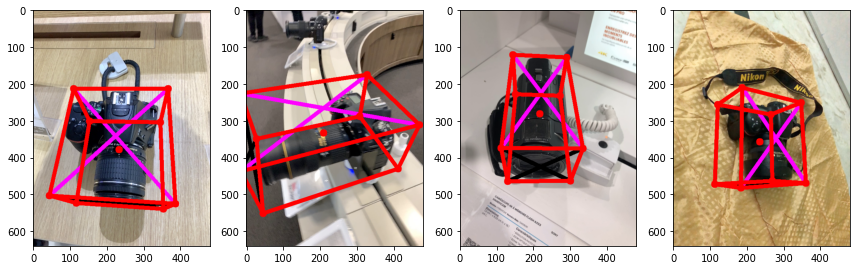

In [48]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/camera/camera_train*')
dataset = load_tf_record(training_shards)
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

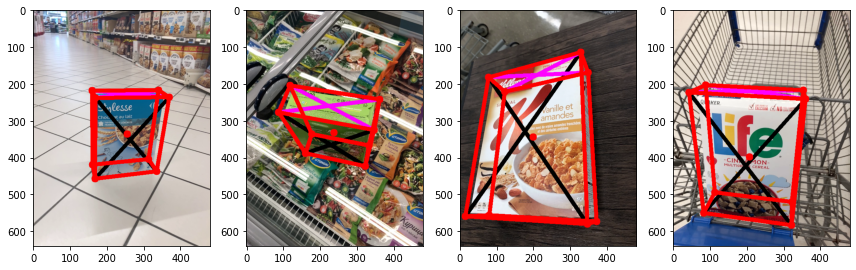

In [49]:
training_shards   = tf.io.gfile.glob(objectron_buckett + '/cereal_box/cereal_box_train*')
dataset = load_tf_record(training_shards)
num_rows = 1
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].\
  values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()